First 5 Rows:
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                

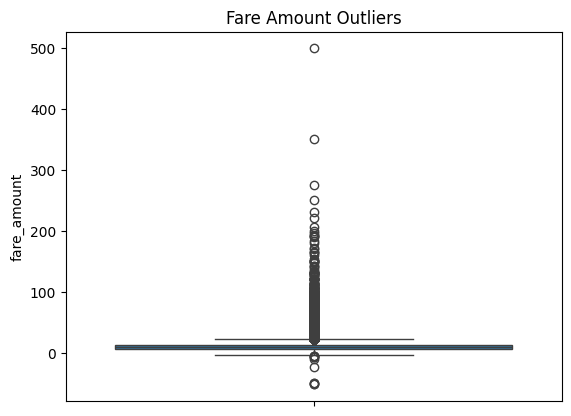

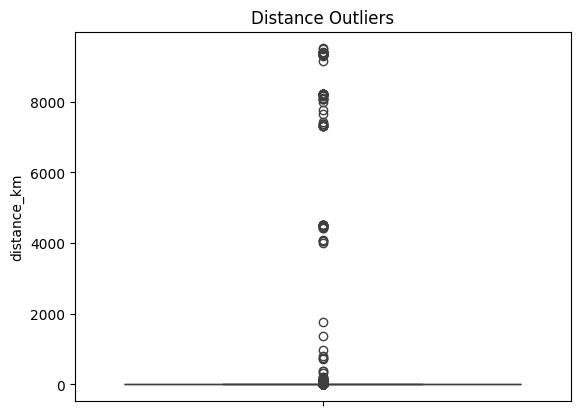


Correlation Matrix:


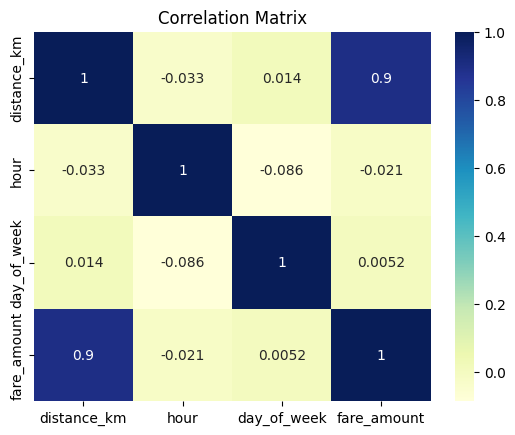


Model Evaluation Scores:
Linear Regression - R2 Score: 0.793, RMSE: 4.204, MAE: 2.256
Ridge Regression - R2 Score: 0.793, RMSE: 4.204, MAE: 2.256
Lasso Regression - R2 Score: 0.793, RMSE: 4.204, MAE: 2.258


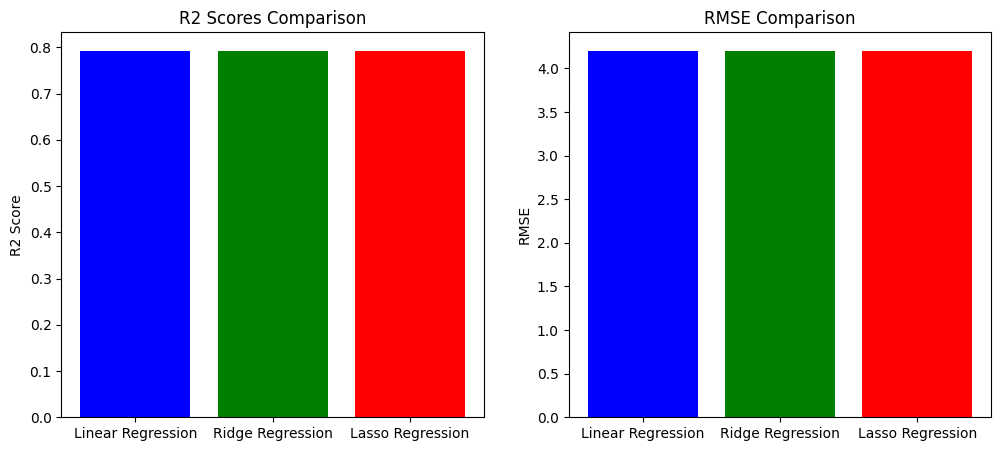

In [11]:
# Step 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 2: Load Dataset
# Adjust the file path to your downloaded Uber dataset CSV
data = pd.read_csv('uber.csv')

# Step 3: Inspect the Data
print("First 5 Rows:")
print(data.head())
print("\nDataset Info:")
print(data.info())

# Step 4: Clean the Data
# Drop rows with missing values
data.dropna(inplace=True)

# Filter out rows with invalid latitude and longitude values
data = data[(data['pickup_latitude'] >= -90) & (data['pickup_latitude'] <= 90)]
data = data[(data['dropoff_latitude'] >= -90) & (data['dropoff_latitude'] <= 90)]
data = data[(data['pickup_longitude'] >= -180) & (data['pickup_longitude'] <= 180)]
data = data[(data['dropoff_longitude'] >= -180) & (data['dropoff_longitude'] <= 180)]

# Convert date columns to datetime format
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract useful information from datetime
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour
data.drop(['pickup_datetime'], axis=1, inplace=True)

# Step 5: Approximate Distance Calculation
# Use a simplified formula for calculating distances between lat/lon points
def approximate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2) * 111  # Approximate conversion to km

# Calculate distance and add it as a new column
data['distance_km'] = approximate_distance(data['pickup_latitude'], data['pickup_longitude'], 
                                           data['dropoff_latitude'], data['dropoff_longitude'])

# Drop unnecessary columns
data = data[['distance_km', 'hour', 'day_of_week', 'fare_amount']]

# Step 6: Identify Outliers
# Visualize the distribution of 'fare_amount' and 'distance_km'
sns.boxplot(data['fare_amount'])
plt.title("Fare Amount Outliers")
plt.show()

sns.boxplot(data['distance_km'])
plt.title("Distance Outliers")
plt.show()

# Remove outliers based on reasonable thresholds
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 100)]
data = data[(data['distance_km'] > 0) & (data['distance_km'] < 50)]

# Step 7: Correlation Analysis
print("\nCorrelation Matrix:")
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

# Step 8: Train-Test Split
X = data.drop('fare_amount', axis=1)
y = data['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Implement Regression Models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Step 10: Evaluate Models
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - R2 Score: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

print("\nModel Evaluation Scores:")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# Visualize Model Performance
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
r2_scores = [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_ridge), r2_score(y_test, y_pred_lasso)]
rmse_scores = [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_ridge)), np.sqrt(mean_squared_error(y_test, y_pred_lasso))]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color=['blue', 'green', 'red'])
plt.title('R2 Scores Comparison')
plt.ylabel('R2 Score')

plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color=['blue', 'green', 'red'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.show()
